In [53]:
import pandas as pd
import os

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [55]:
import numpy as np
from sklearn import metrics
import pickle

In [56]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [57]:
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [58]:
import statutils
from math import sqrt
from sklearn.metrics import roc_auc_score
import sklearn
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import mannwhitneyu

In [59]:
sklearn.__version__

'0.20.3'

In [60]:
from collections import defaultdict

In [61]:
import sys
sys.path.append("/cellarold/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')
import myvariant
mv = myvariant.MyVariantInfo()

### make PRS from top clumped variants

#### extract clumped variants

In [62]:
def make_extract(direct):
    extract=[]
    for x in [x for x in os.listdir(direct) if "clumped" in x]:
        clump=pd.read_csv(direct+x,delim_whitespace=True)
        extract=extract+clump["SNP"].tolist()
    print(len(extract))
    df=pd.DataFrame({"extract":extract})
    return(df)

In [63]:
afr_extract=make_extract("../data/plink-associations/clump/african/")
afr_extract.to_csv("../genotypes/african/extract.txt",header=None,index=None,sep="\t")

10


In [64]:
eur_extract=make_extract("../data/plink-associations/clump/european/")
eur_extract.to_csv("../genotypes/european/extract.txt",header=None,index=None,sep="\t")

7


In [65]:
eur_afr_extract=make_extract("../data/plink-associations/clump/european-african/")
eur_afr_extract.to_csv("../genotypes/european-african/extract.txt",header=None,index=None,sep="\t")

14


In [66]:
[x for x in afr_extract["extract"] if x in eur_afr_extract["extract"].tolist()]

['8:128074135:GCAGGAGAA:G',
 '8:128103969:C:T',
 '8:128162026:G:A',
 '8:128124916:C:A']

#### combine raw files

In [19]:
def make_prs(raw_dir,sumstats):
    
    '''
    Description: function to construct PRS
    
    Inputs: 
        raw_dir: directory with PLINK raw genotype files
        sumstats: file with weights for each snp
        
    Outputs:
        raw_prs: pandas dataframe with IDs and PRS
        
    '''
    
    print(len(snps))
    
    #compile raw files
    raw_files=[x for x in os.listdir(raw_dir) if "raw" in x]
    compiled_raw=pd.read_csv(raw_dir+raw_files[0],delim_whitespace=True)
    del compiled_raw["FID"]
    del compiled_raw["MAT"]
    del compiled_raw["PAT"]
    del compiled_raw["PHENOTYPE"]
    del compiled_raw["SEX"]

    for x in raw_files[1:]:
        raw=pd.read_csv(raw_dir+x,delim_whitespace=True)
        del raw["FID"]
        del raw["MAT"]
        del raw["PAT"]
        del raw["PHENOTYPE"]
        del raw["SEX"]
        compiled_raw=pd.merge(compiled_raw,raw,on="IID",how="left")
    
    #format raw files
    compiled_raw=compiled_raw.set_index("IID")
    compiled_raw=compiled_raw.T
    compiled_raw["min_allele"]=compiled_raw.index.str.split("_").str[-1]
    compiled_raw.index=compiled_raw.index.str.rsplit(":",2).str[0]
    
    summary_merge=sumstats[["ID","A1","OR"]].copy()
    summary_merge=summary_merge.set_index("ID")
    summary_merge.index=summary_merge.index.str.rsplit(":",2).str[0]
    
    compiled_raw=pd.merge(compiled_raw,summary_merge, left_index=True,right_index=True,how="left")
    print("{} snps missing weight".format(len(compiled_raw[compiled_raw["OR"].isnull()])))
    
    compiled_raw["logOR"]=np.log10(compiled_raw["OR"])
    del compiled_raw["OR"]

    compiled_raw=compiled_raw[~compiled_raw["logOR"].isnull()] #remove null weights
    compiled_raw["logOR"]=np.where(compiled_raw["min_allele"]!=compiled_raw["A1"],compiled_raw["logOR"]*-1,compiled_raw["logOR"])
    print("switching {} genotypes".format(len(compiled_raw[compiled_raw["min_allele"]!=compiled_raw["A1"]])))
    
    del compiled_raw["min_allele"]
    del compiled_raw["A1"]

    mp_beta=dict(zip(compiled_raw.index,compiled_raw["logOR"]))
    compiled_raw_switch=compiled_raw.iloc[:,:-1].T
    
    #align to all positive snps
    switch_snps=[k for k,v in mp_beta.items() if v < 0]
    
    for x in switch_snps:
        compiled_raw_switch[x]=2-compiled_raw_switch[x]
    compiled_raw_switch=compiled_raw_switch.T
    compiled_raw_switch["beta"]=compiled_raw_switch.index.map(mp_beta)
    compiled_raw_switch=compiled_raw_switch.astype(float)
    compiled_raw_switch["beta"]=abs(compiled_raw_switch["beta"])
    
    raw_prs=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0).sum(axis=0).reset_index()
    raw_prs.columns=["IID","PRS"]
    
    return(raw_prs)

In [20]:
def map_clinical(df):
    
    '''
    Description: annotate any dataframe with ELLIPSE clinical information
    
    Inputs: 
        df: dataframe
    '''
    
    #get affection status, age, fh
    pheno=pd.read_csv("/cellar/controlled/users/mpagadal/oncoarray/phenotypes/pheno_affection_status.txt",header=None,delimiter="\t")
    age=pd.read_csv("/cellar/controlled/users/mpagadal/oncoarray/phenotypes/oncoarray_age.txt",delimiter="\t",header=None)
    fh=pd.read_csv("/cellar/controlled/users/mpagadal/oncoarray/phenotypes/oncoarray_subject_phenotypes.txt",delimiter="\t")
    
    #make dictionaries
    mp_pheno=dict(zip(pheno[1],pheno[2]))
    mp_age=dict(zip(age[1],age[2]))
    mp_fh=dict(zip(fh["IID"],fh["FH_PROS"]))
    
    #annotate dataframe
    df["status"]=df["IID"].map(mp_pheno)
    df["age"]=df["IID"].map(mp_age)
    df["fh"]=df["IID"].map(mp_fh)
    df["fh"]=df["fh"].replace(-9,0)
    
    df["Genetics"]=(df["PRS"])
    df["Age"]=(df["age"]/df["age"].max())
    df["FH"]=(df["fh"])
    df["FH+Age+Genetics"]=df["fh"]+(df["age"]/df["age"].max())+df["Genetics"]
    return(df)
    

In [34]:
def quantile_plot(df,form,num,lin_log):
    
    '''
    df: dataframe with PRS and pheno/cov in form
    prs: prs column
    form: formula for analysis
    num: number of quantiles
    '''
    
    if lin_log == "logistic":
        
        quant=[]
        odds=[]
        se=[]

        for i in range(num):
            quant.append(str((100/num)*i))
    
            #make groupings for logistic regression
            
            cases=df[(df["PRS"]>df["PRS"].quantile((1/num)*i))&(df["PRS"]<df["PRS"].quantile((1/num)*(i+1)))]["IID"].tolist()
            controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(df["PRS"]<df["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["IID"].tolist()
    
            df_filt=df[df["IID"].isin(cases+controls)]
            df_filt["group"]=np.where(df_filt["IID"].isin(cases),1,0)
            print(df_filt["group"].value_counts())
            
            if i != int(num/2):
                model=smf.logit(form,data=df_filt).fit()
                odds.append(np.exp(model.params.tolist()[1]))
                se.append(model.bse.tolist()[1])
            else:
                odds.append(1)
                se.append(0)
                
        df_odds=pd.DataFrame({"quant":quant,"odds":odds,"se":se})
        return(df_odds)

In [80]:
def map_rsid(x):
    
    '''
    Input: SNP format (chr:bp:minor:major or rsid)
    Output: tuple (variant,rsid)
    '''
    
    try:
        if "rs" in x:
            try:
                var=(re.findall('\d+',mv.getvariants(x)[0]["_id"]))[0]+":"+(re.findall('\d+',mv.getvariants(x)[0]["_id"]))[1]+":"+re.split("[^a-zA-Z]*",mv.getvariants(x)[0]["_id"])[-4]+":"+re.split("[^a-zA-Z]*",mv.getvariants(x)[0]["_id"])[-2]
                rs=x
            except:
                var=np.nan
                rs=x
        else:
            try:
                var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[2]+">"+x.split(":")[3]
                rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
            except:
                try:
                    var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
                    rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
                except:
                    var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
                    rs=np.nan
    except:
        var=np.nan
        rs=np.nan
        
    return (var,rs)

### Run ancestry matched models

In [35]:
compiled_results=pd.DataFrame()

mp_auc = defaultdict(dict)

for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
    for num in range(10):
        print(num)
        
        # get African matched prs
        prstate_summary=pd.read_csv("../data/plink-associations/train_cross/african."+str(num+1)+".train.GWAS.ADD",delimiter="\t")
        snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
        prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
        african_prs=make_prs("../genotypes/african/",prstate_summary)
        african_prs=map_clinical(african_prs)
        
        #specific train and test sets
        train=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
        test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
        prs_train=african_prs[african_prs["IID"].isin(train[1].tolist())]
        prs_test=african_prs[african_prs["IID"].isin(test[1].tolist())]
        
        X_train=prs_train[y]
        y_train=prs_train["status"]

        X_test=prs_test[y]
        y_test=prs_test["status"]
        
        #define model
        fpr, tpr, thresholds = roc_curve(y_test,X_test,pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        
        mp_auc[y][num]=roc_auc
        
        results=pd.DataFrame({"true":y_test,"predicted":X_test,"method":"raw","iteration":num,"category":y})
        compiled_results=compiled_results.append(results)



0
10
0 snps missing weight
switching 1 genotypes
1
10
0 snps missing weight
switching 1 genotypes
2
10
0 snps missing weight
switching 1 genotypes
3
10
0 snps missing weight
switching 1 genotypes
4
10
0 snps missing weight
switching 1 genotypes
5
10
0 snps missing weight
switching 1 genotypes
6
10
0 snps missing weight
switching 1 genotypes
7
10
0 snps missing weight
switching 1 genotypes
8
10
0 snps missing weight
switching 1 genotypes
9
10
0 snps missing weight
switching 1 genotypes
0
10
0 snps missing weight
switching 1 genotypes
1
10
0 snps missing weight
switching 1 genotypes
2
10
0 snps missing weight
switching 1 genotypes
3
10
0 snps missing weight
switching 1 genotypes
4
10
0 snps missing weight
switching 1 genotypes
5
10
0 snps missing weight
switching 1 genotypes
6
10
0 snps missing weight
switching 1 genotypes
7
10
0 snps missing weight
switching 1 genotypes
8
10
0 snps missing weight
switching 1 genotypes
9
10
0 snps missing weight
switching 1 genotypes


###### run pROC

In [36]:
compiled_results.to_csv("../data/proc/compiled.matched.prs.ancestry.results.csv",index=None)

In [37]:
compiled_results=pd.read_csv("../data/proc/compiled.matched.prs.ancestry.results.csv")
proc=pd.read_csv("../data/proc/pROC.compiled.matched.prs.ancestry.results.csv")
compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

(4994, 10)
(4994, 10)
(4994, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4994, 10)
(4994, 10)
(4994, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)
(4983, 10)


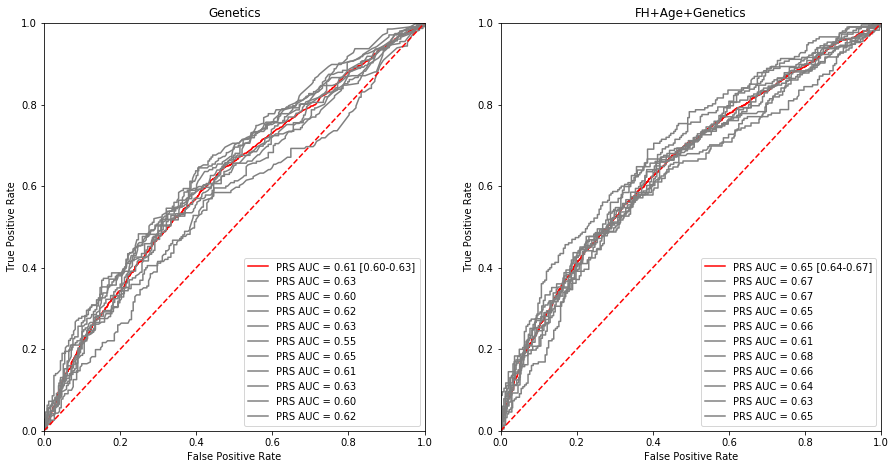

In [38]:
fig, axs = plt.subplots(1, 2,figsize=(15,7.5))
axli = axs.flatten()

for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
    results=compiled_results[compiled_results["category"]==y]
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="raw"]["auc"].tolist()[0],results[results["method"]=="raw"]["lower"].tolist()[0],results[results["method"]=="raw"]["upper"].tolist()[0]),color="red")

    for num in range(10):
        
        results=compiled_results[(compiled_results["category"]==y)&(compiled_results["iteration"]==num)]
        print(results.shape)
        fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f}'.format(roc_auc),color="gray")
        
    #get clump_prs
    axli[i].plot([0, 1], [0, 1],'r--')
    axli[i].legend(loc = 'lower right')
    axli[i].set_title(y)
    axli[i].set_ylabel('True Positive Rate')
    axli[i].set_xlabel('False Positive Rate')
    axli[i].set_xlim([0,1])
    axli[i].set_ylim([0,1])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig("../plots/prs/afr.prs.match.model.pdf")
plt.show()


In [39]:
best_auc=sorted(mp_auc["Genetics"], key=mp_auc["Genetics"].get, reverse=True)[0]+1
print("{} best auc".format(best_auc))
prstate_summary=pd.read_csv("../data/plink-associations/train_cross/african."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
prstate_prs=make_prs("../genotypes/african/",prstate_summary)
prstate_prs=map_clinical(prstate_prs)

6 best auc
10
0 snps missing weight
switching 1 genotypes


In [40]:
african_pts=pd.read_csv("../patients/all/african.cohort.txt",header=None,sep='\t')
european_pts=pd.read_csv("../patients/all/european.cohort.txt",header=None,sep='\t')

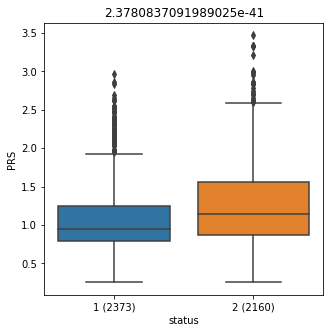

In [41]:
f=plt.figure(figsize=(5,5))

prstate_african_prs=prstate_prs[prstate_prs["IID"].isin(african_pts[1].tolist())]
african_prs[african_prs["IID"].isin(african_pts[1].tolist())]
ax=sns.boxplot(x="status",y="PRS",data=prstate_african_prs)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(prstate_african_prs[prstate_african_prs["status"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = prstate_african_prs[(prstate_african_prs["status"]==1)]
cat2 = prstate_african_prs[(prstate_african_prs["status"]==2)]
plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/prs/afr.match.prs.afr.boxplot.pdf")

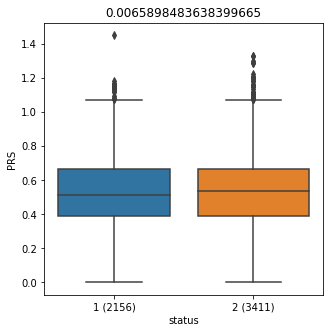

In [42]:
f=plt.figure(figsize=(5,5))

prstate_european_prs=prstate_prs[prstate_prs["IID"].isin(european_pts[1].tolist())]
ax=sns.boxplot(x="status",y="PRS",data=prstate_european_prs)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(prstate_european_prs[prstate_european_prs["status"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = prstate_european_prs[(prstate_european_prs["status"]==1)]
cat2 = prstate_european_prs[(prstate_european_prs["status"]==2)]
plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/prs/afr.match.prs.eur.boxplot.pdf")

In [44]:
#get odds ratios
prstate_african_prs["status"]=prstate_african_prs["status"].map({2:1,1:0})
african_odds=quantile_plot(prstate_african_prs,"status ~ group + Age + FH", 10, "logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1    437
0    432
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.651216
         Iterations 5
0    432
1    389
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.658736
         Iterations 5
1    434
0    432
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.668914
         Iterations 5
0    432
1    412
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.650630
         Iterations 5
1    485
0    432
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.673174
         Iterations 4
1    432
Name: group, dtype: int64
1    449
0    432
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.668045
         Iterations 5
1    433
0    432
Name: group, dtype: int64
Optimization terminated successfully.
       

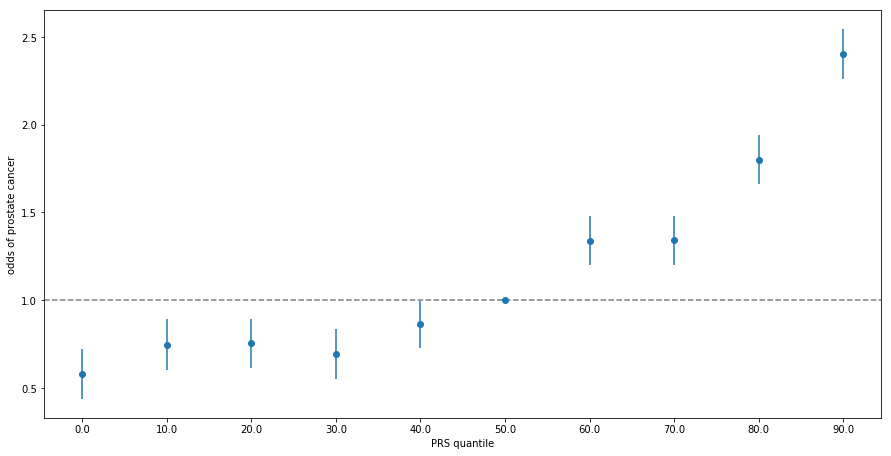

In [45]:
f=plt.figure(figsize=(15,7.5))
plt.errorbar(x=african_odds["quant"].tolist(),y=african_odds["odds"].tolist(),yerr=african_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/prs.match.afr.quantile.pdf")

## Get mismatched models

In [47]:
mp_auc = defaultdict(dict)

compiled_results=pd.DataFrame()

for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
    for num in range(10):
        print(num)
        
        # get European PRS
        prstate_summary=pd.read_csv("../data/plink-associations/train_cross/european."+str(num+1)+".train.GWAS.ADD",delimiter="\t")
        snps=pd.read_csv("../genotypes/european/extract.txt",header=None)[0].tolist()
        prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
        african_prs=make_prs("../genotypes/european/",prstate_summary)
        african_prs=map_clinical(african_prs)
        
        #specific train and test sets
        train=pd.read_csv("../patients/test_train_cross/european."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
        test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
        prs_train=african_prs[african_prs["IID"].isin(train[1].tolist())]
        prs_test=african_prs[african_prs["IID"].isin(test[1].tolist())]
        
        X_train=prs_train[y]
        y_train=prs_train["status"]

        X_test=prs_test[y]
        y_test=prs_test["status"]
        
        #define model
        fpr, tpr, thresholds = roc_curve(y_test,X_test,pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        
        mp_auc[y][num]=roc_auc
        
        results=pd.DataFrame({"true":y_test,"predicted":X_test,"method":"raw","iteration":num,"category":y})
        compiled_results=compiled_results.append(results)


0
7
0 snps missing weight
switching 2 genotypes
1
7
0 snps missing weight
switching 2 genotypes
2
7
0 snps missing weight
switching 2 genotypes
3
7
0 snps missing weight
switching 2 genotypes
4
7
0 snps missing weight
switching 2 genotypes
5
7
0 snps missing weight
switching 2 genotypes
6
7
0 snps missing weight
switching 2 genotypes
7
7
0 snps missing weight
switching 2 genotypes
8
7
0 snps missing weight
switching 2 genotypes
9
7
0 snps missing weight
switching 2 genotypes
0
7
0 snps missing weight
switching 2 genotypes
1
7
0 snps missing weight
switching 2 genotypes
2
7
0 snps missing weight
switching 2 genotypes
3
7
0 snps missing weight
switching 2 genotypes
4
7
0 snps missing weight
switching 2 genotypes
5
7
0 snps missing weight
switching 2 genotypes
6
7
0 snps missing weight
switching 2 genotypes
7
7
0 snps missing weight
switching 2 genotypes
8
7
0 snps missing weight
switching 2 genotypes
9
7
0 snps missing weight
switching 2 genotypes


In [48]:
compiled_results.to_csv("../data/proc/compiled.mismatched.prs.ancestry.results.csv",index=None)

In [49]:
proc=pd.read_csv("../data/proc/pROC.compiled.mismatched.prs.ancestry.results.csv")
compiled_results=pd.read_csv("../data/proc/compiled.mismatched.prs.ancestry.results.csv")
compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

In [62]:
best_auc=sorted(mp_auc["Genetics"], key=mp_auc["Genetics"].get, reverse=True)[0]+1
print("{} best auc".format(best_auc))
prstate_summary=pd.read_csv("../data/plink-associations/train_cross/european."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
snps=pd.read_csv("../genotypes/european/extract.txt",header=None)[0].tolist()
prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
prstate_prs=make_prs("../genotypes/european/",prstate_summary)
prstate_prs=map_clinical(prstate_prs)

3 best auc


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


7
0 snps missing weight
switching 2 genotypes


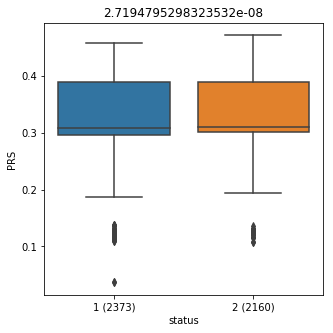

In [63]:
f=plt.figure(figsize=(5,5))

prstate_african_prs=prstate_prs[prstate_prs["IID"].isin(african_pts[1].tolist())]
african_prs[african_prs["IID"].isin(african_pts[1].tolist())]
ax=sns.boxplot(x="status",y="PRS",data=prstate_african_prs)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(prstate_african_prs[prstate_african_prs["status"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = prstate_african_prs[(prstate_african_prs["status"]==1)]
cat2 = prstate_african_prs[(prstate_african_prs["status"]==2)]
plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/prs/afr.mismatch.prs.afr.boxplot.pdf")

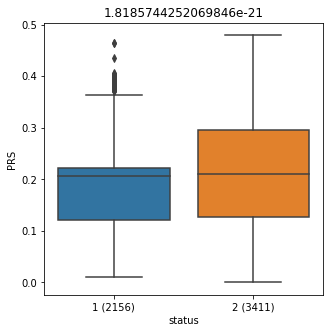

In [64]:
f=plt.figure(figsize=(5,5))

prstate_european_prs=prstate_prs[prstate_prs["IID"].isin(european_pts[1].tolist())]
ax=sns.boxplot(x="status",y="PRS",data=prstate_european_prs)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(prstate_european_prs[prstate_european_prs["status"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = prstate_european_prs[(prstate_european_prs["status"]==1)]
cat2 = prstate_european_prs[(prstate_european_prs["status"]==2)]
plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/prs/afr.mismatch.prs.eur.boxplot.pdf")

In [65]:
prstate_african_prs["status"]=prstate_african_prs["status"].map({2:1,1:0})
african_odds=quantile_plot(prstate_african_prs,"status ~ group + Age + FH",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1    453
0    251
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.645229
         Iterations 5
1    436
0    251
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.666907
         Iterations 4
0    251
1    180
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.675605
         Iterations 4
1    375
0    251
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.673153
         Iterations 5
1    314
0    251
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.665369
         Iterations 5
1    251
Name: group, dtype: int64
0    251
1    235
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.677916
         Iterations 5
1    290
0    251
Name: group, dtype: int64
Optimization terminated successfully.
       

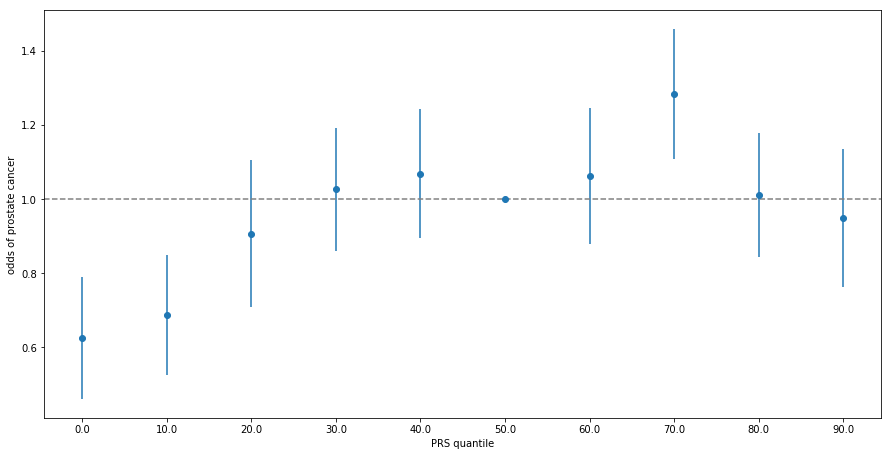

In [66]:
f=plt.figure(figsize=(15,7.5))
plt.errorbar(x=african_odds["quant"].tolist(),y=african_odds["odds"].tolist(),yerr=african_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/prs/prs.mismatch.afr.quantile.pdf")

## Get mixed model

In [67]:
mp_auc = defaultdict(dict)
compiled_results=pd.DataFrame()

for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
    for num in range(10):
        print(num)
        
        # get European PRS
        prstate_summary=pd.read_csv("../data/plink-associations/train_cross/european.african."+str(num+1)+".train.GWAS.ADD",delimiter="\t")
        snps=pd.read_csv("../genotypes/european-african/extract.txt",header=None)[0].tolist()
        prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
        african_prs=make_prs("../genotypes/european-african/",prstate_summary)
        african_prs=map_clinical(african_prs)
        
        #specific train and test sets
        train=pd.read_csv("../patients/test_train_cross/european."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
        test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
        prs_train=african_prs[african_prs["IID"].isin(train[1].tolist())]
        prs_test=african_prs[african_prs["IID"].isin(test[1].tolist())]
        
        X_train=prs_train[y]
        y_train=prs_train["status"]

        X_test=prs_test[y]
        y_test=prs_test["status"]
        
        #define model
        fpr, tpr, thresholds = roc_curve(y_test,X_test,pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        
        mp_auc[y][num]=roc_auc
        
        results=pd.DataFrame({"true":y_test,"predicted":X_test,"method":"raw","iteration":num,"category":y})
        compiled_results=compiled_results.append(results)


0
14
0 snps missing weight
switching 1 genotypes
1
14
0 snps missing weight
switching 1 genotypes
2
14
0 snps missing weight
switching 1 genotypes
3
14
0 snps missing weight
switching 1 genotypes
4
14
0 snps missing weight
switching 1 genotypes
5
14
0 snps missing weight
switching 1 genotypes
6
14
0 snps missing weight
switching 1 genotypes
7
14
0 snps missing weight
switching 1 genotypes
8
14
0 snps missing weight
switching 1 genotypes
9
14
0 snps missing weight
switching 1 genotypes
0
14
0 snps missing weight
switching 1 genotypes
1
14
0 snps missing weight
switching 1 genotypes
2
14
0 snps missing weight
switching 1 genotypes
3
14
0 snps missing weight
switching 1 genotypes
4
14
0 snps missing weight
switching 1 genotypes
5
14
0 snps missing weight
switching 1 genotypes
6
14
0 snps missing weight
switching 1 genotypes
7
14
0 snps missing weight
switching 1 genotypes
8
14
0 snps missing weight
switching 1 genotypes
9
14
0 snps missing weight
switching 1 genotypes


In [68]:
compiled_results.to_csv("../data/proc/compiled.mixed.prs.ancestry.results.csv",index=None)

In [69]:
proc=pd.read_csv("../data/proc/pROC.compiled.mixed.prs.ancestry.results.csv")
compiled_results=pd.read_csv("../data/proc/compiled.mixed.prs.ancestry.results.csv")
compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)


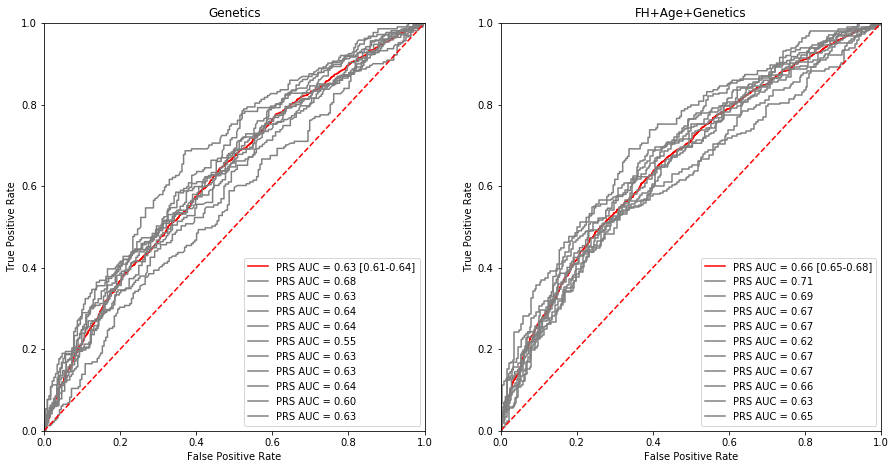

In [70]:
fig, axs = plt.subplots(1, 2,figsize=(15,7.5))
axli = axs.flatten()

for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
    results=compiled_results[compiled_results["category"]==y]
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="raw"]["auc"].tolist()[0],results[results["method"]=="raw"]["lower"].tolist()[0],results[results["method"]=="raw"]["upper"].tolist()[0]),color="red")

    for num in range(10):
        
        results=compiled_results[(compiled_results["category"]==y)&(compiled_results["iteration"]==num)]
        print(results.shape)
        fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f}'.format(roc_auc),color="gray")
        
    #get clump_prs
    axli[i].plot([0, 1], [0, 1],'r--')
    axli[i].legend(loc = 'lower right')
    axli[i].set_title(y)
    axli[i].set_ylabel('True Positive Rate')
    axli[i].set_xlabel('False Positive Rate')
    axli[i].set_xlim([0,1])
    axli[i].set_ylim([0,1])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig("../plots/prs/afr.prs.mixed.model.pdf")
plt.show()


In [71]:
best_auc=sorted(mp_auc["Genetics"], key=mp_auc["Genetics"].get, reverse=True)[0]+1
print("{} best auc".format(best_auc))
prstate_summary=pd.read_csv("../data/plink-associations/train_cross/european.african."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
snps=pd.read_csv("../genotypes/european-african/extract.txt",header=None)[0].tolist()
prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
prstate_prs=make_prs("../genotypes/european-african/",prstate_summary)
prstate_prs=map_clinical(prstate_prs)

1 best auc
14
0 snps missing weight
switching 1 genotypes


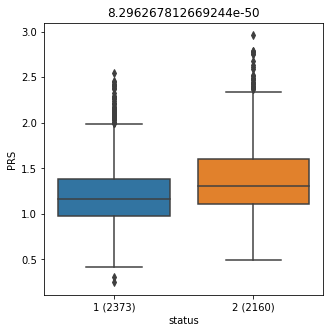

In [72]:
f=plt.figure(figsize=(5,5))

prstate_african_prs=prstate_prs[prstate_prs["IID"].isin(african_pts[1].tolist())]
african_prs[african_prs["IID"].isin(african_pts[1].tolist())]
ax=sns.boxplot(x="status",y="PRS",data=prstate_african_prs)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(prstate_african_prs[prstate_african_prs["status"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = prstate_african_prs[(prstate_african_prs["status"]==1)]
cat2 = prstate_african_prs[(prstate_african_prs["status"]==2)]
plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/prs/trans.prs.afr.boxplot.pdf")

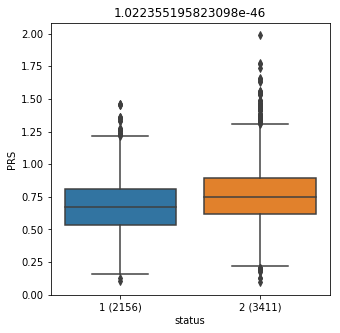

In [73]:
f=plt.figure(figsize=(5,5))

prstate_european_prs=prstate_prs[prstate_prs["IID"].isin(european_pts[1].tolist())]
ax=sns.boxplot(x="status",y="PRS",data=prstate_european_prs)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(prstate_european_prs[prstate_european_prs["status"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = prstate_european_prs[(prstate_european_prs["status"]==1)]
cat2 = prstate_european_prs[(prstate_european_prs["status"]==2)]
plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/prs/trans.prs.eur.boxplot.pdf")

In [74]:
prstate_african_prs["status"]=prstate_african_prs["status"].map({2:1,1:0})
african_odds=quantile_plot(prstate_african_prs,"status ~ group + Age + FH",10,"logistic")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1    453
0    452
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.636922
         Iterations 5
1    452
0    452
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.658055
         Iterations 5
1    452
0    452
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.655013
         Iterations 5
0    452
1    447
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.674744
         Iterations 4
0    452
1    451
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.662421
         Iterations 5
1    452
Name: group, dtype: int64
1    452
0    452
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.673065
         Iterations 4
1    452
0    452
Name: group, dtype: int64
Optimization terminated successfully.
       

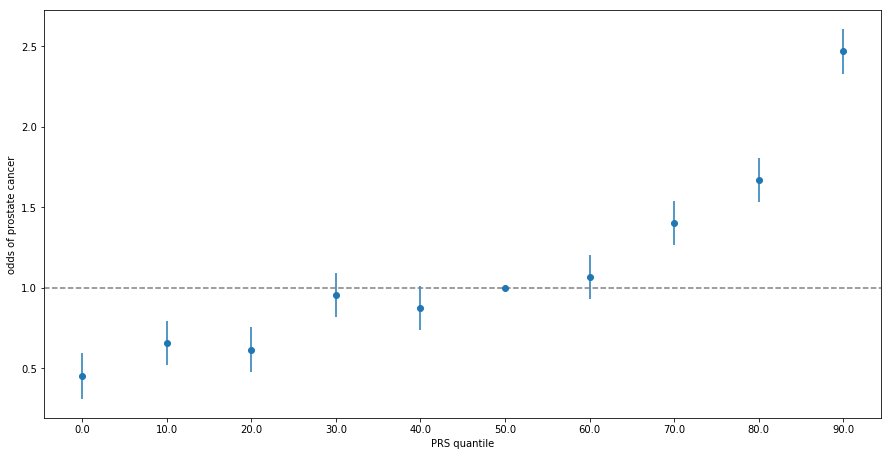

In [75]:
f=plt.figure(figsize=(15,7.5))
plt.errorbar(x=african_odds["quant"].tolist(),y=african_odds["odds"].tolist(),yerr=african_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/prs/prs.trans.afr.quantile.pdf")

### get summary statistics for african PRS

In [76]:
gwas=pd.read_csv("../data/plink-associations/train_cross/african.6.train.GWAS.ADD",delimiter="\t")
extract=pd.read_csv("../genotypes/african/extract.txt",header=None)
gwas_filt=gwas[gwas["ID"].isin(extract[0].tolist())]

In [77]:
gwas_stats=gwas_filt[["ID","A1","OR","P"]]
gwas_stats["logOR"]=np.log10(gwas_stats["OR"])

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
gwas_stats.to_csv("../data/plink-associations/sumstats/african.match.crossfold.6.best.stats.tsv",index=None,sep="\t")

### get african-specific variants

In [81]:
afr_extract['rsid'] = afr_extract['extract'].apply(lambda x: map_rsid(x)[1])

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.


In [82]:
afr_extract[~afr_extract["rsid"].isnull()]["rsid"].to_csv("../data/extract.afr.rsid.extract.txt",header=None,index=None,sep="\t")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


### get overlapping variants

In [83]:
# overlap=[x for x in afr_extract["extract"] if x in eur_afr_extract["extract"].tolist()]
overlap=[x for x in afr_extract["extract"]]

In [84]:
eur=pd.read_csv("../data/plink-associations/all/european.cohort.GWAS.ADD",delim_whitespace=True)
afr=pd.read_csv("../data/plink-associations/all/african.cohort.GWAS.ADD",delim_whitespace=True)
eur_afr=pd.read_csv("../data/plink-associations/all/european.african.cohort.GWAS.ADD",delim_whitespace=True)

In [113]:
eur_gwas_stats=eur[eur["SNP"].isin(overlap)]
afr_gwas_stats=afr[afr["SNP"].isin(overlap)]
eur_afr_gwas_stats=eur_afr[eur_afr["SNP"].isin(overlap)]

In [114]:
gwas_compare=pd.merge(eur_gwas_stats[["SNP","A1","OR","LOG(OR)_SE"]],afr_gwas_stats[["SNP","A1","OR","LOG(OR)_SE"]],on="SNP",how="left",suffixes=("_eur","_afr"))
gwas_compare=pd.merge(gwas_compare,eur_afr_gwas_stats[["SNP","A1","OR","LOG(OR)_SE"]],on="SNP",how="left")

In [115]:
gwas_compare["OR_eur"]=np.log10(gwas_compare["OR_eur"])
gwas_compare["OR_afr"]=np.log10(gwas_compare["OR_afr"])
gwas_compare["OR"]=np.log10(gwas_compare["OR"])

In [116]:
gwas_compare["OR_afr"]=np.where(gwas_compare["A1_afr"]!=gwas_compare["A1_eur"],gwas_compare["OR_afr"]*-1,gwas_compare["OR_afr"])
gwas_compare["OR"]=np.where(gwas_compare["A1"]!=gwas_compare["A1_eur"],gwas_compare["OR"]*-1,gwas_compare["OR"])

In [117]:
gwas_compare=gwas_compare.set_index("SNP")

In [118]:
gwas_compare["OR_eur"]=np.exp(gwas_compare["OR_eur"])
gwas_compare["OR_afr"]=np.exp(gwas_compare["OR_afr"])
gwas_compare["OR"]=np.exp(gwas_compare["OR"])

In [119]:
gwas_compare=gwas_compare.reset_index()
gwas_compare=pd.melt(gwas_compare, id_vars=["SNP"], value_vars=["OR_eur","LOG(OR)_SE_eur","OR_afr","LOG(OR)_SE_afr","OR","LOG(OR)_SE"])

In [120]:
gwas_compare["group"]=gwas_compare["variable"].str.split("_").str[-1]
gwas_compare["group"]=gwas_compare["group"].replace({"OR":"trans","SE":"trans"})
gwas_compare["variable"]=gwas_compare["variable"].str.replace("_eur","")
gwas_compare["variable"]=gwas_compare["variable"].str.replace("_afr","")

In [121]:
gwas_compare["variable"].unique()

array(['OR', 'LOG(OR)_SE'], dtype=object)

In [74]:
gwas_or=gwas_compare[(gwas_compare["variable"]=="OR")]
gwas_err=gwas_compare[(gwas_compare["variable"]=="LOG(OR)_SE")]

In [75]:
gwas_plot=pd.merge(gwas_or, gwas_err, on=["SNP","group"],how="left",suffixes=("_OR","_SE"))

In [76]:
gwas_plot["name"]=gwas_plot["SNP"]+" "+gwas_plot["group"]

In [77]:
gwas_plot.head()

,SNP,variable_OR,value_OR,group,variable_SE,value_SE,name
0,11:68995278:G:A,OR,1.083411,eur,LOG(OR)_SE,0.056892,11:68995278:G:A eur
1,3:169491729:T:A,OR,0.989066,eur,LOG(OR)_SE,0.045615,3:169491729:T:A eur
2,8:128074135:GCAGGAGAA:G,OR,0.991986,eur,LOG(OR)_SE,0.203558,8:128074135:GCAGGAGAA:G eur
3,8:128103969:C:T,OR,1.057849,eur,LOG(OR)_SE,0.050682,8:128103969:C:T eur
4,8:128124916:C:A,OR,1.215543,eur,LOG(OR)_SE,0.109540,8:128124916:C:A eur


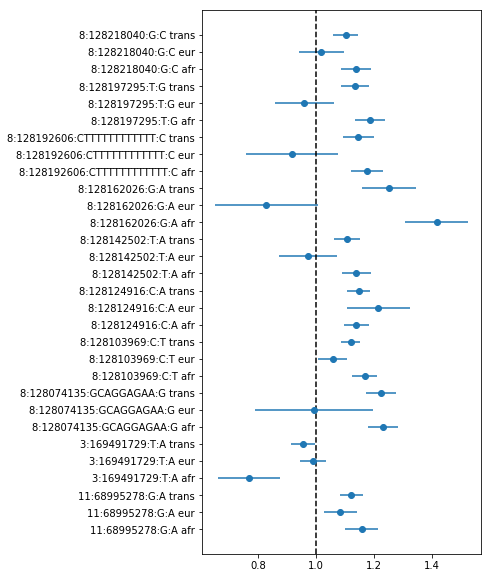

In [78]:
f=plt.figure(figsize=(5,10))
gwas_plot=gwas_plot.sort_values(by=["SNP","group"])
gwas_plot["value_OR"]=gwas_plot["value_OR"].astype(float)
gwas_plot["value_SE"]=gwas_plot["value_SE"].astype(float)
plt.errorbar(gwas_plot["value_OR"],gwas_plot["name"],xerr=gwas_plot["value_SE"],fmt="o")
plt.axvline(1,linestyle="--",color="k")
plt.savefig("../plots/gwas.compare.errplot.pdf")

### make SNP data frame

In [79]:
extract_compiled=afr_extract.copy()
extract_compiled["group"]="African"

In [80]:
eur_extract["group"]="European"
eur_afr_extract["group"]="European+African"

In [81]:
extract_compiled=extract_compiled.append(eur_extract)
extract_compiled=extract_compiled.append(eur_afr_extract)

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [82]:
extract_compiled.to_csv("../data/supplemental/Supplemental_Table_4.csv",index=None)

### Get conti et al snps

In [67]:
conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
conti=conti[~conti["Position"].isnull()]
conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]

### Determine if snps overlap with conti et al

In [86]:
nearest=[]
snp_lst=[]
dist_lst=[]

for x in afr_extract["extract"].tolist():
    nearest_snp=conti[conti["Chromosome"]==int(x.split(":")[0])]
    nearest_snp["diff"]=abs(nearest_snp["Position"]-int(x.split(":")[1]))
    snp_lst.append(x)
    nearest.append(nearest_snp.sort_values(by="diff")["variant"].tolist()[0])
    dist_lst.append(nearest_snp.sort_values(by="diff")["diff"].tolist()[0])

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [87]:
df_afr_nearest=pd.DataFrame({"snp":snp_lst,"nearest_snp":nearest,"dist":dist_lst})

In [88]:
df_afr_nearest.to_csv("../data/conti.afr.compare.tsv",index=None,sep="\t")

In [89]:
nearest=[]
snp_lst=[]
dist_lst=[]

for x in eur_extract["extract"].tolist():
    nearest_snp=conti[conti["Chromosome"]==int(x.split(":")[0])]
    nearest_snp["diff"]=abs(nearest_snp["Position"]-int(x.split(":")[1]))
    snp_lst.append(x)
    nearest.append(nearest_snp.sort_values(by="diff")["variant"].tolist()[0])
    dist_lst.append(nearest_snp.sort_values(by="diff")["diff"].tolist()[0])

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [90]:
df_eur_nearest=pd.DataFrame({"snp":snp_lst,"nearest_snp":nearest,"dist":dist_lst})

In [91]:
df_eur_nearest.to_csv("../data/conti.eur.compare.tsv",index=None,sep="\t")

### Get MVP OR

In [92]:
eur_mvp=pd.read_csv("../data/mvp/sumstats/eur.compiled.prstate.glm.hybrid",delim_whitespace=True)
afr_mvp=pd.read_csv("../data/mvp/sumstats/afr.compiled.prstate.glm.hybrid",delim_whitespace=True)

eur_mvp["prostate"]=eur_mvp["file"].str.split(".").str[1]
afr_mvp["prostate"]=afr_mvp["file"].str.split(".").str[1]

In [93]:
overlap_extract=overlap+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in overlap]

In [94]:
gwas_compare=pd.merge(eur_mvp[["ID","A1","OR","LOG(OR)_SE","prostate"]],afr_mvp[["ID","A1","OR","LOG(OR)_SE","prostate"]],on=["ID","prostate"],how="left",suffixes=("_eur","_afr"))

In [95]:
gwas_compare=gwas_compare[gwas_compare["ID"].isin(overlap_extract)]

In [96]:
gwas_compare["OR_eur"]=np.log10(gwas_compare["OR_eur"])
gwas_compare["OR_afr"]=np.log10(gwas_compare["OR_afr"])

In [97]:
gwas_compare["OR_afr"]=np.where(gwas_compare["A1_afr"]!=gwas_compare["A1_eur"],gwas_compare["OR_afr"]*-1,gwas_compare["OR_afr"])

In [98]:
gwas_compare=gwas_compare.reset_index()
gwas_compare=pd.melt(gwas_compare, id_vars=["ID","prostate"], value_vars=["OR_eur","LOG(OR)_SE_eur","OR_afr","LOG(OR)_SE_afr"])

In [99]:
gwas_compare["group"]=gwas_compare["variable"].str.split("_").str[-1]
gwas_compare["group"]=gwas_compare["group"].replace({"OR":"trans","SE":"trans"})
gwas_compare["variable"]=gwas_compare["variable"].str.replace("_eur","")
gwas_compare["variable"]=gwas_compare["variable"].str.replace("_afr","")

In [100]:
gwas_or=gwas_compare[(gwas_compare["variable"]=="OR")]
gwas_err=gwas_compare[(gwas_compare["variable"]=="LOG(OR)_SE")]

In [101]:
gwas_plot=pd.merge(gwas_or, gwas_err, on=["ID","group","prostate"],how="left",suffixes=("_OR","_SE"))

In [102]:
gwas_plot["name"]=gwas_plot["ID"]+" "+gwas_plot["group"]

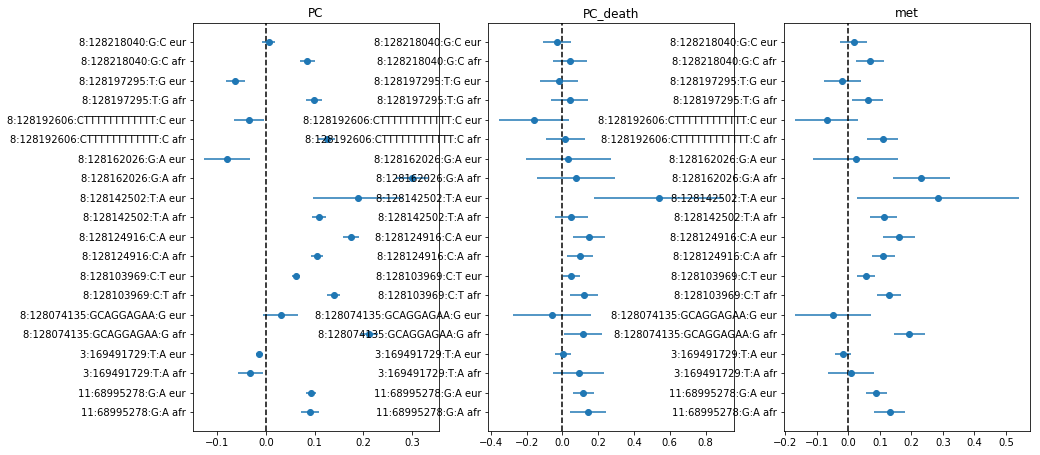

In [103]:
fig, axs = plt.subplots(1, 3,figsize=(15,7.5))
axli = axs.flatten()

for i,pc in enumerate(gwas_plot["prostate"].unique()):
    gwas_plot_pc=gwas_plot[gwas_plot["prostate"]==pc]
    gwas_plot_pc=gwas_plot_pc.sort_values(by=["ID","group"])
    gwas_plot_pc["value_OR"]=gwas_plot_pc["value_OR"].astype(float)
    gwas_plot_pc["value_SE"]=gwas_plot_pc["value_SE"].astype(float)
    axli[i].errorbar(gwas_plot_pc["value_OR"],gwas_plot_pc["name"],xerr=gwas_plot_pc["value_SE"],fmt="o")
    axli[i].set_title(pc)
    axli[i].axvline(0,linestyle="--",color="k")
plt.savefig("../plots/mvp.afr.snps.or.pdf")

## Conti et al Analysis

In [68]:
#get linkage disequilibrium estimates
ld=pd.read_csv("../data/ldlink/combined_query_snp_list.txt",delimiter="\t")
prostate_ld=ld[ld["R2"]>=0.3]

In [69]:
prostate_ld.head()

,query_snp,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function
1,rs11228575,rs11228575,chr11:68995278,(G/A),0.1717,0,1.0000,1.0000,"G=G,A=A",5,NaN
2,rs11228575,rs7130881,chr11:68995958,(A/G),0.1970,680,0.8901,0.6697,"G=A,A=G",4,NaN
3,rs11228575,rs12795301,chr11:68992285,(C/A),0.1970,-2993,0.8901,0.6697,"G=C,A=A",7,NaN
4,rs11228575,rs71046512,chr11:68990715,(G/-),0.1970,-4563,0.8901,0.6697,"G=G,A=-",.,NaN
5,rs11228575,rs11228580,chr11:69002342,(T/C),0.1970,7064,0.8901,0.6697,"G=T,A=C",4,NaN


In [70]:
conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
conti["prstate"]=np.where(conti["snp_noallele"].isin(prostate_ld["Coord"].tolist()),"found","not found")

In [71]:
conti.columns

Index(['rs*', 'Chromosome', 'Position', 'Known/Novel',
       '800 kb from known risk region ', 'Lead Variant Updated†',
       'Risk Allele', 'Reference Allele', 'European', 'African', 'East Asian',
       'Hispanic', 'Multiethnic Analysis', 'Unnamed: 13', 'Unnamed: 14',
       'European.1', 'Unnamed: 16', 'Unnamed: 17', 'African.1', 'Unnamed: 19',
       'Unnamed: 20', 'East Asian.1', 'Unnamed: 22', 'Unnamed: 23',
       'Hispanic.1', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'OR (95% CI), P value', 'Unnamed: 29', 'Unnamed: 30',
       'Risk Allele Frequency', 'Info Score', 'variant', 'snp_noallele',
       'prstate'],
      dtype='object')

In [72]:
conti["Unnamed: 20"].head()

0    0.293700
1    0.241900
2    0.010830
3    0.008518
4    0.006933
Name: Unnamed: 20, dtype: float64

In [75]:
conti.sort_values(by="Unnamed: 20")[["variant","Unnamed: 20","prstate"]]

,variant,Unnamed: 20,prstate
127,8:128074815:T:A,3.950000e-82,not found
129,8:128103969:T:C,5.520000e-29,found
171,11:69002342:C:T,3.990000e-24,found
100,6:117200434:C:A,9.499000e-17,not found
126,8:128027954:G:A,4.710000e-15,not found
118,8:23529521:G:A,1.440000e-12,not found
194,13:110360784:T:C,1.943000e-11,not found
254,22:29091147:C:A,1.350000e-09,not found
41,2:238411293:C:T,4.190000e-09,not found
184,12:53308932:A:C,5.240000e-09,not found


In [ ]:
# compiled_results=pd.DataFrame()
# mp_auc = defaultdict(dict)

# for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
#     for num in range(10):
        
#         # get traditional prs
        
#         prstate_summary=pd.read_csv("../results/train_cross/african."+str(num+1)+".train.GWAS.ADD",delimiter="\t")
#         snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
        
#         #get conti prs
        
#         conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
#         conti=conti[~conti["Position"].isnull()]
#         conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
#         conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
#         conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
#         conti=conti[["variant","Risk Allele","African.1"]]
#         conti.columns=["ID","A1","OR"]
        
#         prstate_conti_summary=prstate_summary[prstate_summary["ID"].isin(snps)][["ID","A1","OR"]].append(conti)

#         african_prs=make_prs("../genotypes/african/conti/",prstate_conti_summary,snps,"african_conti")
#         african_prs=map_clinical(african_prs)
        
#         #specific train and test sets
#         train=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
#         test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
#         prs_train=african_prs[african_prs["IID"].isin(train[1].tolist())]
#         prs_test=african_prs[african_prs["IID"].isin(test[1].tolist())]
        
#         X_train=prs_train[y]
#         y_train=prs_train["status"]

#         X_test=prs_test[y]
#         y_test=prs_test["status"]
        
#         #define model
#         fpr, tpr, thresholds = roc_curve(y_test,X_test,pos_label=2)
#         roc_auc =metrics.auc(fpr, tpr)
        
#         mp_auc[y][num]=roc_auc
        
#         results=pd.DataFrame({"true":y_test,"predicted":X_test,"method":"raw","iteration":num,"category":y})
#         compiled_results=compiled_results.append(results)


In [ ]:
# compiled_results.to_csv("../data/proc/compiled.prstate.conti.results.csv",index=None)

In [ ]:
# proc=pd.read_csv("pROC.compiled.matched.prs.ancestry.conti.results.csv")
# compiled_results=pd.read_csv("../data/compiled.matched.prs.ancestry.conti.results.csv")
# compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

In [ ]:
# fig, axs = plt.subplots(1, 2,figsize=(15,7.5))
# axli = axs.flatten()

# for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
#     results=compiled_results[compiled_results["category"]==y]
    
#     fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
#     roc_auc =metrics.auc(fpr, tpr)
#     axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="raw"]["auc"].tolist()[0],results[results["method"]=="raw"]["lower"].tolist()[0],results[results["method"]=="raw"]["upper"].tolist()[0]),color="red")

#     for num in range(10):
        
#         results=compiled_results[(compiled_results["category"]==y)&(compiled_results["iteration"]==num)]
#         print(results.shape)
#         fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
#         roc_auc =metrics.auc(fpr, tpr)
#         axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f}'.format(roc_auc),color="gray")
        
#     #get clump_prs
#     axli[i].plot([0, 1], [0, 1],'r--')
#     axli[i].legend(loc = 'lower right')
#     axli[i].set_title(y)
#     axli[i].set_ylabel('True Positive Rate')
#     axli[i].set_xlabel('False Positive Rate')
#     axli[i].set_xlim([0,1])
#     axli[i].set_ylim([0,1])

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.savefig("../plots/afr.prs.conti.model.pdf")
# plt.show()


In [ ]:
# compiled_results=pd.DataFrame()

# for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
#     for num in range(10):
        
#         # get traditional prs
        
#         conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
#         conti=conti[~conti["Position"].isnull()]
#         conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
#         conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
#         conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
#         conti=conti[["variant","Risk Allele","African.1"]]
#         conti.columns=["ID","A1","OR"]
        
#         african_prs=make_prs("../genotypes/african/conti/",conti,conti["ID"].tolist(),"african_conti")
#         african_prs=map_clinical(african_prs)
        
#         #specific train and test sets
#         train=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
#         test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
#         prs_train=african_prs[african_prs["IID"].isin(train[1].tolist())]
#         prs_test=african_prs[african_prs["IID"].isin(test[1].tolist())]
        
#         X_train=prs_train[y]
#         y_train=prs_train["status"]

#         X_test=prs_test[y]
#         y_test=prs_test["status"]
        
#         #define model
#         fpr, tpr, thresholds = roc_curve(y_test,X_test,pos_label=2)
#         roc_auc =metrics.auc(fpr, tpr)   
#         results=pd.DataFrame({"true":y_test,"predicted":X_test,"method":"raw","iteration":num,"category":y})
#         compiled_results=compiled_results.append(results)



In [ ]:
# compiled_results.to_csv("../data/compiled.matched.prs.ancestry.conti.only.results.csv",index=None)

In [ ]:
# proc=pd.read_csv("pROC.compiled.matched.prs.ancestry.conti.only.results.csv")
# compiled_results=pd.read_csv("../data/compiled.matched.prs.ancestry.conti.only.results.csv")
# compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

In [ ]:
# fig, axs = plt.subplots(1, 2,figsize=(15,7.5))
# axli = axs.flatten()

# for i,y in enumerate(["Genetics","FH+Age+Genetics"]):
    
#     results=compiled_results[compiled_results["category"]==y]
    
#     fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
#     roc_auc =metrics.auc(fpr, tpr)
#     axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="raw"]["auc"].tolist()[0],results[results["method"]=="raw"]["lower"].tolist()[0],results[results["method"]=="raw"]["upper"].tolist()[0]),color="red")

#     for num in range(10):
        
#         results=compiled_results[(compiled_results["category"]==y)&(compiled_results["iteration"]==num)]
#         print(results.shape)
#         fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="raw"]["true"]),np.array(results[results["method"]=="raw"]["predicted"]), pos_label=2)
#         roc_auc =metrics.auc(fpr, tpr)
#         axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f}'.format(roc_auc),color="gray")
        
#     #get clump_prs
#     axli[i].plot([0, 1], [0, 1],'r--')
#     axli[i].legend(loc = 'lower right')
#     axli[i].set_title(y)
#     axli[i].set_ylabel('True Positive Rate')
#     axli[i].set_xlabel('False Positive Rate')
#     axli[i].set_xlim([0,1])
#     axli[i].set_ylim([0,1])

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.savefig("../plots/afr.prs.conti.only.model.pdf")
# plt.show()


### Calculate DeLong statistics

In [ ]:
# conti_prstate=pd.read_csv("../data/compiled.matched.prs.ancestry.conti.results.csv")
# conti_only=pd.read_csv("../data/compiled.matched.prs.ancestry.conti.only.results.csv")

In [56]:
# Functions for DeLong test
def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])

def kernel(X, Y):
    return .5 if Y==X else int(Y < X)

def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

In [ ]:
# dlong_conti=pd.merge(conti_only,conti_prstate,left_index=True,right_index=True,suffixes=("_conti","_conti_prstate"))
# dlong_conti["actual_map"]=dlong_conti["true_conti"].map({2:1,1:0})

# preds_A=dlong_conti[dlong_conti["category_conti"]=="Genetics"]["predicted_conti"].tolist()
# preds_B=dlong_conti[dlong_conti["category_conti"]=="Genetics"]["predicted_conti_prstate"].tolist()
# actual=dlong_conti[dlong_conti["category_conti"]=="Genetics"]["actual_map"].tolist()

In [ ]:
# X_A, Y_A = group_preds_by_label(preds_A, actual)
# X_B, Y_B = group_preds_by_label(preds_B, actual)

# V_A10, V_A01 = structural_components(X_A, Y_A)
# V_B10, V_B01 = structural_components(X_B, Y_B)

# auc_A = auc(X_A, Y_A)
# auc_B = auc(X_B, Y_B)

# # Compute entries of covariance matrix S (covar_AB = covar_BA)
# var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
#              + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
# var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
#              + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
# covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
#                 + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

# # Two tailed test
# z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
# p = st.norm.sf(abs(z))*2
# print(p)
    

In [ ]:
# preds_A=dlong_conti[dlong_conti["category_conti"]=="FH+Age+Genetics"]["predicted_conti"].tolist()
# preds_B=dlong_conti[dlong_conti["category_conti"]=="FH+Age+Genetics"]["predicted_conti_prstate"].tolist()
# actual=dlong_conti[dlong_conti["category_conti"]=="FH+Age+Genetics"]["actual_map"].tolist()

In [ ]:
# X_A, Y_A = group_preds_by_label(preds_A, actual)
# X_B, Y_B = group_preds_by_label(preds_B, actual)

# V_A10, V_A01 = structural_components(X_A, Y_A)
# V_B10, V_B01 = structural_components(X_B, Y_B)

# auc_A = auc(X_A, Y_A)
# auc_B = auc(X_B, Y_B)

# # Compute entries of covariance matrix S (covar_AB = covar_BA)
# var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
#              + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
# var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
#              + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
# covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
#                 + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

# # Two tailed test
# z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
# p = st.norm.sf(abs(z))*2
# print(p)

### Conti et al (LOGREG)

In [43]:
compiled_results=pd.DataFrame()
mp_auc = defaultdict(dict)

for i,category in enumerate(["Conti","PRState","Conti+PRState"]):
    print(category)
    for num in range(10):
        
        # get PRState prs
        print(num)
        prstate_summary=pd.read_csv("../results/train_cross/african."+str(num+1)+".train.GWAS.ADD",delimiter="\t")
        snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
        prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
        prstate_prs=make_prs("../genotypes/african/",prstate_summary,snps,"african")
        prstate_prs=map_clinical(prstate_prs)
        
        # get Conti prs
        
        conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
        conti=conti[~conti["Position"].isnull()]
        conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
        conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
        conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
        conti=conti[["variant","Risk Allele","African.1"]]
        conti.columns=["ID","A1","OR"]
        conti_prs=make_prs("../genotypes/african/conti/",conti,conti["ID"].tolist(),"african_conti")
        
        # get combined prs file
        prstate_prs=prstate_prs.rename(columns={"PRS":"PRState_PRS"})
        conti_prs=conti_prs.rename(columns={"PRS":"Conti_PRS"})
        prstate_conti_prs=pd.merge(prstate_prs,conti_prs,on="IID",how="left")
        
        #specific train and test sets
        train=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
        test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
        prs_train=prstate_conti_prs[prstate_conti_prs["IID"].isin(train[1].tolist())]
        prs_test=prstate_conti_prs[prstate_conti_prs["IID"].isin(test[1].tolist())]
        
        if category == "Conti":
            X_train=prs_train[["Conti_PRS"]]
            y_train=prs_train["status"]

            X_test=prs_test[["Conti_PRS"]]
            y_test=prs_test["status"]
        
        elif category == "PRState":
            X_train=prs_train[["PRState_PRS"]]
            y_train=prs_train["status"]

            X_test=prs_test[["PRState_PRS"]]
            y_test=prs_test["status"]
        
        elif category == "Conti+PRState":
            X_train=prs_train[["Conti_PRS","PRState_PRS"]]
            y_train=prs_train["status"]

            X_test=prs_test[["Conti_PRS","PRState_PRS"]]
            y_test=prs_test["status"]
        
        #define model
        model = linear_model.LogisticRegression(random_state = 331)
        all_probs=(model.fit(np.array(X_train), np.ravel(np.array(y_train).reshape(-1, 1))).predict_proba(np.array(X_test))[:,1])
        fpr, tpr, thresholds = roc_curve(y_test,all_probs,pos_label=2)
    
        roc_auc =metrics.auc(fpr, tpr)
        mp_auc[category][num]=roc_auc
        
        results=pd.DataFrame({"true":y_test,"predicted":all_probs,"method":"logreg","iteration":num,"category":category})
        compiled_results=compiled_results.append(results)



Conti
0


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PRState
0


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Conti+PRState
0


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [45]:
compiled_results.to_csv("../data/proc/compiled.logreg.conti.results.csv",index=None)

In [82]:
proc=pd.read_csv("../data/proc/pROC.compiled.logreg.conti.results.csv")
compiled_results=pd.read_csv("../data/proc/compiled.logreg.conti.results.csv")
compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

In [83]:
results[results["method"]=="raw"]["predicted"]

Series([], Name: predicted, dtype: float64)

(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)


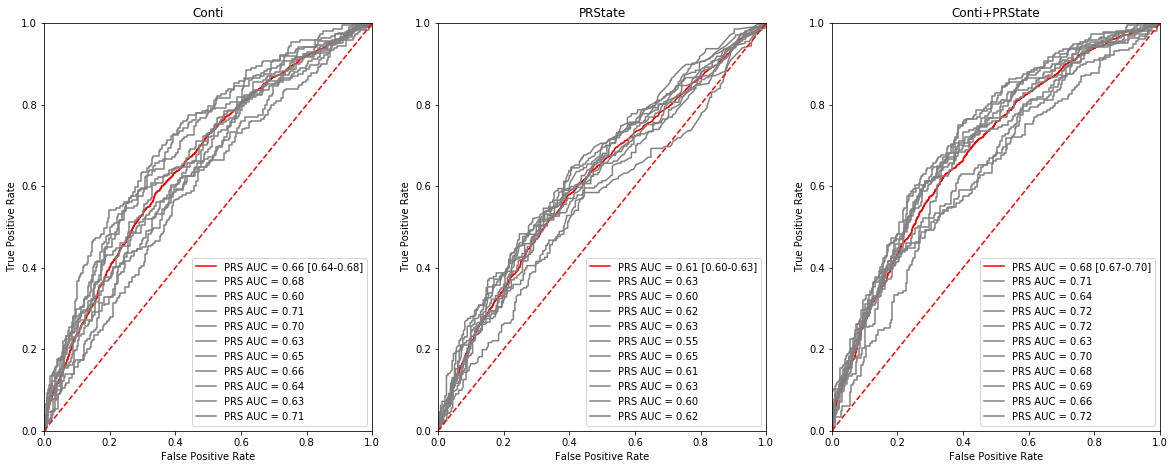

In [84]:
fig, axs = plt.subplots(1, 3,figsize=(20,7.5))
axli = axs.flatten()

for i,y in enumerate(compiled_results["category"].unique().tolist()):
    
    results=compiled_results[compiled_results["category"]==y]
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="logreg"]["true"]),np.array(results[results["method"]=="logreg"]["predicted"]), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="logreg"]["auc"].tolist()[0],results[results["method"]=="logreg"]["lower"].tolist()[0],results[results["method"]=="logreg"]["upper"].tolist()[0]),color="red")

    for num in range(10):
        
        results=compiled_results[(compiled_results["category"]==y)&(compiled_results["iteration"]==num)]
        print(results.shape)
        fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="logreg"]["true"]),np.array(results[results["method"]=="logreg"]["predicted"]), pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f}'.format(roc_auc),color="gray")
        
    #get clump_prs
    axli[i].plot([0, 1], [0, 1],'r--')
    axli[i].legend(loc = 'lower right')
    axli[i].set_title(y)
    axli[i].set_ylabel('True Positive Rate')
    axli[i].set_xlabel('False Positive Rate')
    axli[i].set_xlim([0,1])
    axli[i].set_ylim([0,1])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig("../plots/afr.prstate.conti.logreg.model.pdf")
plt.show()


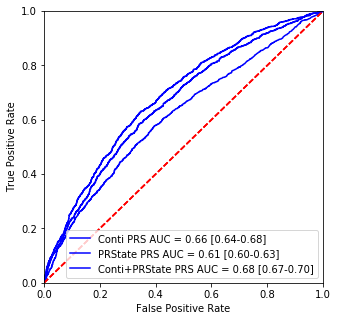

In [95]:
f=plt.figure(figsize=(5,5))

for i,y in enumerate(compiled_results["category"].unique().tolist()):

    results=compiled_results[compiled_results["category"]==y]
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="logreg"]["true"]),np.array(results[results["method"]=="logreg"]["predicted"]), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = y+' PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="logreg"]["auc"].tolist()[0],results[results["method"]=="logreg"]["lower"].tolist()[0],results[results["method"]=="logreg"]["upper"].tolist()[0]))

    #get clump_prs
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig("../plots/afr.prstate.conti.logreg.nofold.model.pdf")
plt.show()


In [51]:
conti_logreg_prs=compiled_results[compiled_results["category"]=="Conti"]
conti_prstate_logreg_prs=compiled_results[compiled_results["category"]=="Conti+PRState"]
conti_logreg_prs=conti_logreg_prs.reset_index()
conti_prstate_logreg_prs=conti_prstate_logreg_prs.reset_index()
compare_prs=pd.merge(conti_logreg_prs,conti_prstate_logreg_prs,left_index=True,right_index=True,suffixes=("_conti","_conti_prstate"))

In [52]:
compare_prs["actual_map"]=compare_prs["true_conti"].map({2:1,1:0})

In [53]:
preds_A=compare_prs["predicted_conti"].tolist()
preds_B=compare_prs["predicted_conti_prstate"].tolist()
actual=compare_prs["actual_map"].tolist()

In [54]:
len(preds_B)

4533

In [58]:
X_A, Y_A = group_preds_by_label(preds_A, actual)
X_B, Y_B = group_preds_by_label(preds_B, actual)

V_A10, V_A01 = structural_components(X_A, Y_A)
V_B10, V_B01 = structural_components(X_B, Y_B)

auc_A = auc(X_A, Y_A)
auc_B = auc(X_B, Y_B)

# Compute entries of covariance matrix S (covar_AB = covar_BA)
var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
             + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
             + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

# Two tailed test
z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
p = st.norm.sf(abs(z))*2
print(p)
    

0.00025597577052466526


In [60]:
mp_auc.keys()

dict_keys(['Conti', 'PRState', 'Conti+PRState'])

In [64]:
for x in mp_auc.keys():
    print(x)
    best_auc=sorted(mp_auc[x], key=mp_auc[x].get, reverse=True)[0]+1
    print("using best AUC: {}".format(best_auc))
    
    #build prstate prs
    prstate_summary=pd.read_csv("../results/train_cross/african."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
    snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
    prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
    prstate_prs=make_prs("../genotypes/african/",prstate_summary,snps,"european")
    prstate_prs=map_clinical(prstate_prs)
    
    #build conti prs
    conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
    conti=conti[~conti["Position"].isnull()]
    conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
    conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
    conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
    conti=conti[["variant","Risk Allele","African.1"]]
    conti.columns=["ID","A1","OR"]
    conti_prs=make_prs("../genotypes/african/conti/",conti,conti["ID"].tolist(),"african_conti")
        
    # get combined prs file
    prstate_prs=prstate_prs.rename(columns={"PRS":"PRState_PRS"})
    conti_prs=conti_prs.rename(columns={"PRS":"Conti_PRS"})
    prstate_conti_prs=pd.merge(prstate_prs,conti_prs[["IID","Conti_PRS"]],on="IID",how="left")
    prstate_conti_prs["status_map"]=prstate_conti_prs["status"].map({2:1,1:0})
    
    if x == "Conti":
        model = linear_model.LogisticRegression(random_state = 331)
        model.fit(prstate_conti_prs[["Conti_PRS"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))
        filename = 'conti.best.logreg.sav'
        pickle.dump(model, open(filename, 'wb'))
    
    elif x == "PRState":
        model = linear_model.LogisticRegression(random_state = 331)
        model.fit(prstate_conti_prs[["PRState_PRS"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))
        filename = 'prstate.best.logreg.sav'
        pickle.dump(model, open(filename, 'wb'))
        
    elif x == "Conti+PRState":
        model = linear_model.LogisticRegression(random_state = 331)
        model.fit(prstate_conti_prs[["Conti_PRS","PRState_PRS"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))
        filename = 'prstate.conti.best.logreg.sav'
        pickle.dump(model, open(filename, 'wb'))

Conti
using best AUC: 3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PRState
using best AUC: 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Conti+PRState
using best AUC: 4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Run Conti with FH and age

In [69]:
compiled_results=pd.DataFrame()
mp_auc = defaultdict(dict)

for i,category in enumerate(["Conti","PRState","Conti+PRState"]):
    print(category)
    for num in range(10):
        
        # get PRState prs
        print(num)
        prstate_summary=pd.read_csv("../results/train_cross/african."+str(num+1)+".train.GWAS.ADD",delimiter="\t")
        snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
        prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
        prstate_prs=make_prs("../genotypes/african/",prstate_summary,snps,"african")
        prstate_prs=map_clinical(prstate_prs)
        
        # get Conti prs
        
        conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
        conti=conti[~conti["Position"].isnull()]
        conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
        conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
        conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
        conti=conti[["variant","Risk Allele","African.1"]]
        conti.columns=["ID","A1","OR"]
        conti_prs=make_prs("../genotypes/african/conti/",conti,conti["ID"].tolist(),"african_conti")
        
        # get combined prs file
        prstate_prs=prstate_prs.rename(columns={"PRS":"PRState_PRS"})
        conti_prs=conti_prs.rename(columns={"PRS":"Conti_PRS"})
        prstate_conti_prs=pd.merge(prstate_prs,conti_prs,on="IID",how="left")
        
        #specific train and test sets
        train=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".train.txt",delim_whitespace=True,header=None)
        test=pd.read_csv("../patients/test_train_cross/african."+str(num+1)+".test.txt",delim_whitespace=True,header=None)
        prs_train=prstate_conti_prs[prstate_conti_prs["IID"].isin(train[1].tolist())]
        prs_test=prstate_conti_prs[prstate_conti_prs["IID"].isin(test[1].tolist())]
        
        if category == "Conti":
            X_train=prs_train[["Conti_PRS","FH","Age"]]
            y_train=prs_train["status"]

            X_test=prs_test[["Conti_PRS","FH","Age"]]
            y_test=prs_test["status"]
        
        elif category == "PRState":
            X_train=prs_train[["PRState_PRS","FH","Age"]]
            y_train=prs_train["status"]

            X_test=prs_test[["PRState_PRS","FH","Age"]]
            y_test=prs_test["status"]
        
        elif category == "Conti+PRState":
            X_train=prs_train[["Conti_PRS","PRState_PRS","FH","Age"]]
            y_train=prs_train["status"]

            X_test=prs_test[["Conti_PRS","PRState_PRS","FH","Age"]]
            y_test=prs_test["status"]
        
        #define model
        model = linear_model.LogisticRegression(random_state = 331)
        all_probs=(model.fit(np.array(X_train), np.ravel(np.array(y_train).reshape(-1, 1))).predict_proba(np.array(X_test))[:,1])
        fpr, tpr, thresholds = roc_curve(y_test,all_probs,pos_label=2)
    
        roc_auc =metrics.auc(fpr, tpr)
        
        results=pd.DataFrame({"true":y_test,"predicted":all_probs,"method":"logreg","iteration":num,"category":category})
        compiled_results=compiled_results.append(results)
        
        mp_auc[category][num]=roc_auc


Conti
0


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PRState
0


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Conti+PRState
0


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [70]:
compiled_results.to_csv("../data/proc/compiled.logreg.conti.fh.age.results.csv",index=None)

In [96]:
proc=pd.read_csv("../data/proc/pROC.compiled.logreg.conti.fh.age.results.csv")
compiled_results=pd.read_csv("../data/proc/compiled.logreg.conti.fh.age.results.csv")
compiled_results=pd.merge(compiled_results,proc,on=["category","method"],how="left")

(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(454, 9)
(454, 9)
(454, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)
(453, 9)


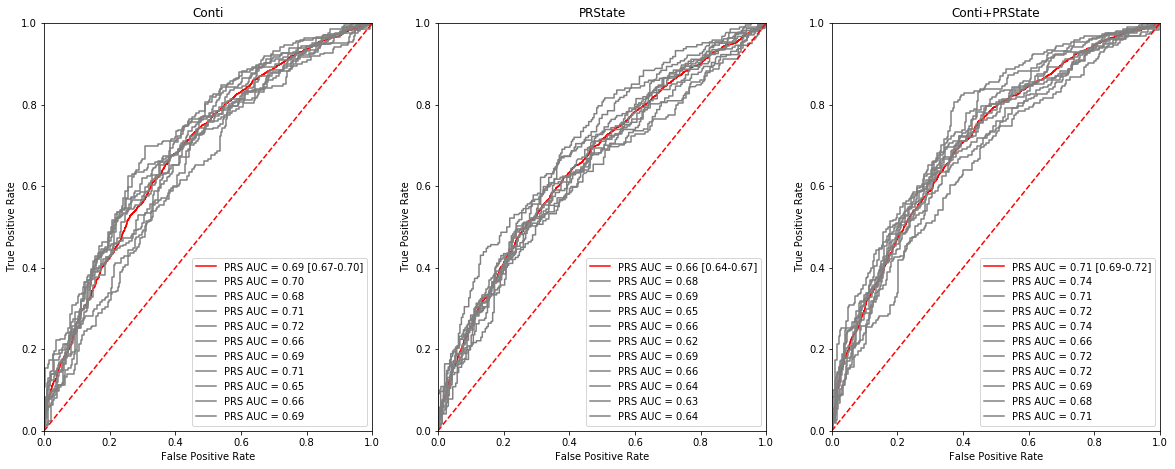

In [97]:
fig, axs = plt.subplots(1, 3,figsize=(20,7.5))
axli = axs.flatten()

for i,y in enumerate(compiled_results["category"].unique().tolist()):
    
    results=compiled_results[compiled_results["category"]==y]
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="logreg"]["true"]),np.array(results[results["method"]=="logreg"]["predicted"]), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="logreg"]["auc"].tolist()[0],results[results["method"]=="logreg"]["lower"].tolist()[0],results[results["method"]=="logreg"]["upper"].tolist()[0]),color="red")

    for num in range(10):
        
        results=compiled_results[(compiled_results["category"]==y)&(compiled_results["iteration"]==num)]
        print(results.shape)
        fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="logreg"]["true"]),np.array(results[results["method"]=="logreg"]["predicted"]), pos_label=2)
        roc_auc =metrics.auc(fpr, tpr)
        axli[i].plot(fpr, tpr, 'b', label = 'PRS AUC = {0:.2f}'.format(roc_auc),color="gray")
        
    #get clump_prs
    axli[i].plot([0, 1], [0, 1],'r--')
    axli[i].legend(loc = 'lower right')
    axli[i].set_title(y)
    axli[i].set_ylabel('True Positive Rate')
    axli[i].set_xlabel('False Positive Rate')
    axli[i].set_xlim([0,1])
    axli[i].set_ylim([0,1])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig("../plots/afr.prstate.conti.fh.logreg.model.pdf")
plt.show()


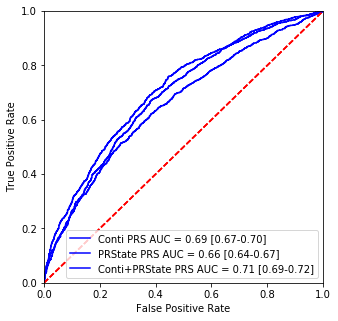

In [98]:
f=plt.figure(figsize=(5,5))

for i,y in enumerate(compiled_results["category"].unique().tolist()):

    results=compiled_results[compiled_results["category"]==y]
    
    fpr, tpr, thresholds = metrics.roc_curve(np.array(results[results["method"]=="logreg"]["true"]),np.array(results[results["method"]=="logreg"]["predicted"]), pos_label=2)
    roc_auc =metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = y+' PRS AUC = {0:.2f} [{1:.2f}-{2:.2f}]'.format(results[results["method"]=="logreg"]["auc"].tolist()[0],results[results["method"]=="logreg"]["lower"].tolist()[0],results[results["method"]=="logreg"]["upper"].tolist()[0]))

    #get clump_prs
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig("../plots/afr.prstate.conti.logreg.nofold.fh.model.pdf")
plt.show()


In [75]:
conti_logreg_prs=compiled_results[compiled_results["category"]=="Conti"]
conti_prstate_logreg_prs=compiled_results[compiled_results["category"]=="Conti+PRState"]
conti_logreg_prs=conti_logreg_prs.reset_index()
conti_prstate_logreg_prs=conti_prstate_logreg_prs.reset_index()
compare_prs=pd.merge(conti_logreg_prs,conti_prstate_logreg_prs,left_index=True,right_index=True,suffixes=("_conti","_conti_prstate"))

In [76]:
compare_prs["actual_map"]=compare_prs["true_conti"].map({2:1,1:0})

In [77]:
preds_A=compare_prs["predicted_conti"].tolist()
preds_B=compare_prs["predicted_conti_prstate"].tolist()
actual=compare_prs["actual_map"].tolist()

In [78]:
X_A, Y_A = group_preds_by_label(preds_A, actual)
X_B, Y_B = group_preds_by_label(preds_B, actual)

V_A10, V_A01 = structural_components(X_A, Y_A)
V_B10, V_B01 = structural_components(X_B, Y_B)

auc_A = auc(X_A, Y_A)
auc_B = auc(X_B, Y_B)

# Compute entries of covariance matrix S (covar_AB = covar_BA)
var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
             + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
             + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

# Two tailed test
z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
p = st.norm.sf(abs(z))*2
    

In [79]:
p

0.00028203509242800224

In [81]:
for x in mp_auc.keys():
    print(x)
    best_auc=sorted(mp_auc[x], key=mp_auc[x].get, reverse=True)[0]+1
    print("using best AUC: {}".format(best_auc))
    
    #build prstate prs
    prstate_summary=pd.read_csv("../results/train_cross/african."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
    snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
    prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
    prstate_prs=make_prs("../genotypes/african/",prstate_summary,snps,"european")
    prstate_prs=map_clinical(prstate_prs)
    
    #build conti prs
    conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
    conti=conti[~conti["Position"].isnull()]
    conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
    conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
    conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
    conti=conti[["variant","Risk Allele","African.1"]]
    conti.columns=["ID","A1","OR"]
    conti_prs=make_prs("../genotypes/african/conti/",conti,conti["ID"].tolist(),"african_conti")
        
    # get combined prs file
    prstate_prs=prstate_prs.rename(columns={"PRS":"PRState_PRS"})
    conti_prs=conti_prs.rename(columns={"PRS":"Conti_PRS"})
    prstate_conti_prs=pd.merge(prstate_prs,conti_prs[["IID","Conti_PRS"]],on="IID",how="left")
    prstate_conti_prs["status_map"]=prstate_conti_prs["status"].map({2:1,1:0})
    
    if x == "Conti":
        model = linear_model.LogisticRegression(random_state = 331)
        model.fit(prstate_conti_prs[["Conti_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))
        filename = 'conti.fh.best.logreg.sav'
        pickle.dump(model, open(filename, 'wb'))
    
    elif x == "PRState":
        model = linear_model.LogisticRegression(random_state = 331)
        model.fit(prstate_conti_prs[["PRState_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))
        filename = 'prstate.fh.best.logreg.sav'
        pickle.dump(model, open(filename, 'wb'))
        
    elif x == "Conti+PRState":
        model = linear_model.LogisticRegression(random_state = 331)
        model.fit(prstate_conti_prs[["Conti_PRS","PRState_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))
        filename = 'prstate.conti.fh.best.logreg.sav'
        pickle.dump(model, open(filename, 'wb'))

Conti
using best AUC: 4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


PRState
using best AUC: 6


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Conti+PRState
using best AUC: 4


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
0 snps missing weight
switching 1 genotypes
264
28 snps missing weight
switching 126 genotypes


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [138]:
best_auc=sorted(mp_auc["Conti+PRState"], key=mp_auc["Conti+PRState"].get, reverse=True)[0]+1
prstate_summary=pd.read_csv("../results/train_cross/african."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
prstate_prs=make_prs("../genotypes/european-african/",prstate_summary,snps,"european")
prstate_prs=map_clinical(prstate_prs)

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


10
10 snps missing weight
switching 1 genotypes


In [139]:
best_auc=sorted(mp_auc["Conti+PRState"], key=mp_auc["Conti+PRState"].get, reverse=True)[0]+1
prstate_summary=pd.read_csv("../results/train_cross/african."+str(best_auc)+".train.GWAS.ADD",delimiter="\t")
snps=pd.read_csv("../genotypes/african/extract.txt",header=None)[0].tolist()
prstate_summary=prstate_summary[prstate_summary["ID"].isin(snps)]
prstate_prs=make_prs("../genotypes/european-african/",prstate_summary,snps,"european")
prstate_prs=map_clinical(prstate_prs)

conti=pd.read_excel("/cellar/users/mpagadal/data/conti_et_al/41588_2020_748_MOESM3_ESM.xlsx",sheet_name=3,skiprows=[0,1,2])
conti=conti[~conti["Position"].isnull()]
conti["variant"]=conti["Chromosome"].astype(str)+":"+conti["Position"].astype(int).astype(str)+":"+conti["Risk Allele"]+":"+conti["Reference Allele"]
conti["snp_noallele"]="chr"+conti["variant"].str.rsplit(":",2).str[0]
conti=conti[~conti["snp_noallele"].isin(prostate_ld["Coord"].tolist())]
conti=conti[["variant","Risk Allele","African.1"]]
conti.columns=["ID","A1","OR"]
conti_prs=make_prs("../genotypes/african/conti/",conti,conti["ID"].tolist(),"african_conti")
        
# get combined prs file
prstate_prs=prstate_prs.rename(columns={"PRS":"PRState_PRS"})
conti_prs=conti_prs.rename(columns={"PRS":"Conti_PRS"})
prstate_conti_prs=pd.merge(prstate_prs,conti_prs,on="IID",how="left")

model = linear_model.LogisticRegression(random_state = 331)
model.fit(prstate_conti_prs[["Conti_PRS","PRState_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))


filename = 'prstate.conti.fh.age.logreg.sav'
pickle.dump(model, open(filename, 'wb'))

264
28 snps missing weight
switching 126 genotypes


In [140]:
pts=pd.read_csv("../patients/all/african.cohort.txt",header=None,delimiter="\t")
prstate_conti_prs=prstate_conti_prs[prstate_conti_prs["IID"].isin(pts[1].tolist())]

In [141]:
prstate_conti_prs["status_map"]=prstate_conti_prs["status"].map({2:1,1:0})

In [142]:
model = linear_model.LogisticRegression(random_state = 331)
model.fit(prstate_conti_prs[["Conti_PRS","PRState_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=331, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [143]:
filename = 'prstate.conti.fh.age.logreg.sav'
pickle.dump(model, open(filename, 'wb'))

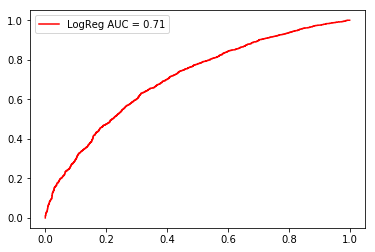

In [144]:
loaded_model = pickle.load(open(filename, 'rb'))

all_probs=loaded_model.predict_proba(prstate_conti_prs[["Conti_PRS","PRState_PRS","FH","Age"]])[:,1]
fpr, tpr, thresholds = roc_curve(prstate_conti_prs["status_map"],all_probs,pos_label=1)
        
roc_auc =metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'LogReg AUC = %0.2f' % roc_auc,color="red")
plt.legend()


In [145]:
model = linear_model.LogisticRegression(random_state = 331)
model.fit(prstate_conti_prs[["Conti_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=331, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [146]:
filename = 'conti.fh.age.logreg.sav'
pickle.dump(model, open(filename, 'wb'))

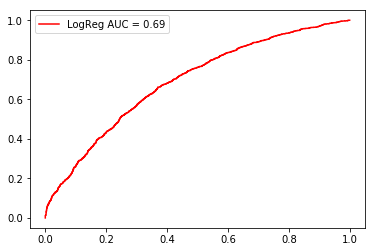

In [147]:
loaded_model = pickle.load(open(filename, 'rb'))

all_probs=loaded_model.predict_proba(prstate_conti_prs[["Conti_PRS","FH","Age"]])[:,1]
fpr, tpr, thresholds = roc_curve(prstate_conti_prs["status_map"],all_probs,pos_label=1)
        
roc_auc =metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'LogReg AUC = %0.2f' % roc_auc,color="red")
plt.legend()


In [148]:
model = linear_model.LogisticRegression(random_state = 331)
model.fit(prstate_conti_prs[["PRState_PRS","FH","Age"]], np.ravel(np.array(prstate_conti_prs["status_map"]).reshape(-1, 1)))

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=331, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [149]:
filename = 'prstate.fh.age.logreg.sav'
pickle.dump(model, open(filename, 'wb'))

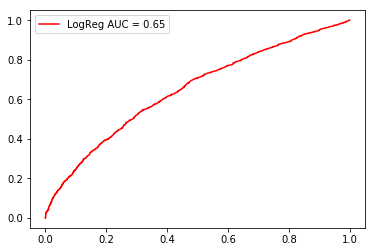

In [150]:
loaded_model = pickle.load(open(filename, 'rb'))

all_probs=loaded_model.predict_proba(prstate_conti_prs[["PRState_PRS","FH","Age"]])[:,1]
fpr, tpr, thresholds = roc_curve(prstate_conti_prs["status_map"],all_probs,pos_label=1)
        
roc_auc =metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'LogReg AUC = %0.2f' % roc_auc,color="red")
plt.legend()


### Get confidence intervals of MVP

In [118]:
compiled_mvp=pd.DataFrame()
for x in os.listdir("../data/mvp/"):
    mvp=pd.read_csv("../data/mvp/"+x)
    mvp["file"]=x
    compiled_mvp=compiled_mvp.append(mvp)

In [125]:
compiled_mvp[(compiled_mvp["group"]=="eur")&(compiled_mvp["file"]=="pc.death.pROC.txt")]

,Unnamed: 0,lower,auc,upper,category,group,file
1,2,0.502268,0.517739,0.533210,prstate_only,eur,pc.death.pROC.txt
3,4,0.583121,0.598105,0.613088,conti_only,eur,pc.death.pROC.txt
5,6,0.583958,0.598920,0.613881,prstate_conti,eur,pc.death.pROC.txt


### Conduct raw logistic regression

In [431]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [122]:
logreg = LogisticRegression()

In [131]:
prstate_conti_prs["status_map"]=prstate_conti_prs["status"].map({2:1,1:0})

In [135]:
prstate_conti_prs.head()

,IID,PRState_PRS,status,age,fh,Genetics,Age,FH,FH+Age+Genetics,Conti_PRS,status_map
0,0008701_0008701,1.004330,1,69.0,0,1.004330,0.669903,0,1.674233,7.340439,0
1,0028701_0028701,0.245285,1,62.0,0,0.245285,0.601942,0,0.847227,7.144862,0
2,0032003_0032003,0.780484,1,51.0,1,0.780484,0.495146,1,2.275629,7.053024,0
3,0033901_0033901,0.617394,1,54.0,0,0.617394,0.524272,0,1.141666,6.954095,0
4,0038804_0038804,0.390198,1,44.0,0,0.390198,0.427184,0,0.817383,7.198604,0


In [138]:
african=pd.read_csv("../patients/all/african.cohort.txt",header=None,sep="\t")

In [140]:
model=smf.logit("status_map ~ PRState_PRS + Conti_PRS + Age + FH",data=prstate_conti_prs).fit()

Optimization terminated successfully.
         Current function value: 0.584736
         Iterations 6


In [141]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             status_map   No. Observations:                91644
Model:                          Logit   Df Residuals:                    91639
Method:                           MLE   Df Model:                            4
Date:                Wed, 16 Feb 2022   Pseudo R-squ.:                  0.1350
Time:                        09:22:32   Log-Likelihood:                -53588.
converged:                       True   LL-Null:                       -61951.
                                        LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -19.4791      0.207    -93.920      0.000     -19.886     -19.073
PRState_PRS     0.0822      0.025      3.251      0.001       0.033       0.132
Conti_PRS       2.2838      0.027     83.306      0.000       2.230       2.338
Age             5.8001      0.085     68.359      0.000       5.634       5.966
FH              0.6935      0.025     28.124      0.000       0.645       0.742
===============================================================================
"""

In [144]:
prstate_conti_prs_african=prstate_conti_prs[prstate_conti_prs["IID"].isin(african[1].tolist())]

In [145]:
model=smf.logit("status_map ~ PRState_PRS + Conti_PRS + Age + FH",data=prstate_conti_prs_african).fit()

Optimization terminated successfully.
         Current function value: 0.615518
         Iterations 5


In [146]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             status_map   No. Observations:                 4533
Model:                          Logit   Df Residuals:                     4528
Method:                           MLE   Df Model:                            4
Date:                Wed, 16 Feb 2022   Pseudo R-squ.:                  0.1106
Time:                        09:23:07   Log-Likelihood:                -2790.1
converged:                       True   LL-Null:                       -3137.0
                                        LLR p-value:                7.780e-149
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -18.7749      0.969    -19.378      0.000     -20.674     -16.876
PRState_PRS     0.8674      0.070     12.418      0.000       0.730       1.004
Conti_PRS       2.2132      0.129     17.187      0.000       1.961       2.466
Age             2.8700      0.350      8.191      0.000       2.183       3.557
FH              0.9840      0.101      9.740      0.000       0.786       1.182
===============================================================================
"""

In [148]:
european=pd.read_csv("../patients/all/european.cohort.txt",header=None,sep="\t")

In [149]:
prstate_conti_prs_european=prstate_conti_prs[prstate_conti_prs["IID"].isin(european[1].tolist())]

In [150]:
model=smf.logit("status_map ~ PRState_PRS + Conti_PRS + Age + FH",data=prstate_conti_prs_european).fit()

Optimization terminated successfully.
         Current function value: 0.576943
         Iterations 6


In [151]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             status_map   No. Observations:                 5567
Model:                          Logit   Df Residuals:                     5562
Method:                           MLE   Df Model:                            4
Date:                Wed, 16 Feb 2022   Pseudo R-squ.:                  0.1357
Time:                        09:23:46   Log-Likelihood:                -3211.8
converged:                       True   LL-Null:                       -3716.1
                                        LLR p-value:                5.254e-217
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -18.2696      0.836    -21.852      0.000     -19.908     -16.631
PRState_PRS     0.2921      0.138      2.111      0.035       0.021       0.563
Conti_PRS       2.0876      0.111     18.879      0.000       1.871       2.304
Age             6.0619      0.354     17.108      0.000       5.367       6.756
FH              0.8546      0.103      8.259      0.000       0.652       1.057
===============================================================================
"""